## Read and Process HTML files ##

In [8]:
import pandas as pd
from bs4 import BeautifulSoup

from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
import re
import unicodedata as ud

d = {ord('\N{COMBINING ACUTE ACCENT}'):None}

# Read html file
def read_file(file_path: str) -> list:
    with open(file_path, 'r') as file:
        html_content = file.read()
    soup = BeautifulSoup(html_content, 'html.parser')
    text = soup.get_text()
    list_words = text.replace('\n', ' ').split(' ')
    return list_words

In [9]:
import os

files = os.listdir('./final_dataset_efeteio')
files = [f for f in files if f.endswith('.html')]

df = pd.DataFrame(columns=['script'])
for f in files:
    list_words = read_file(f'./final_dataset_efeteio/{f}')
    script = ' '.join(list_words)
    df.loc[f] = script    

df.sort_index(inplace=True)
df.head()

,script
1004.html,αριθμος αποφασης αριθμος αποφασης αριθμο...
1006.html,αριθμος αποφασης αριθμος αποφασης εφετει...
1008.html,αριθμος αποφασης αριθμος αποφασης εφετει...
1010.html,αριθμος αποφασης αριθμος αποφασης εφετει...
1012.html,αριθμος αποφασης αριθμος αποφασης εφετει...


In [10]:
df.shape

(3498, 1)

In [11]:
decisions = pd.read_csv('./preprocessed_efeteio/annotated_dataset.csv')    
decisions = decisions[decisions['Decision'].isin(df.index)]
decisions.set_index('Decision', inplace=True)
decisions.sort_index(inplace=True)
decisions.head()

,Label
Decision,
1004.html,1
1006.html,1
1008.html,1
1010.html,1
1012.html,0


In [12]:
decisions

,Label
Decision,
1004.html,1
1006.html,1
1008.html,1
1010.html,1
1012.html,0
...,...
9686.html,0
9688.html,1
969.html,1


In [13]:
decisions.value_counts()

Label
1        3101
0         397
Name: count, dtype: int64

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata

def preprocess_text(file_path):
    with open(file_path, 'r') as file:
        # Read the text from the file
        text = file.read()
        # Convert to lowercase
        text = text.lower()
        # Remove accents
        text = ''.join(char for char in unicodedata.normalize('NFKD', text) if not unicodedata.combining(char))
        # Remove punctuations
        text = re.sub(r'[^\w\s]', '', text)
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Remove English characters
        text = re.sub(r'[a-zA-Z]', '', text)
        # Remove all special chars
        text = text.replace('_', '')
        # Transforn to list of words
        text = text.replace('\n', ' ').split(' ')
    return text

# Example usage:
stop_words = preprocess_text('stopwords.txt')

In [16]:
data

,αα,αβασιμα,αβασιμες,αβασιμη,αβασιμης,αβασιμο,αβασιμοι,αβασιμος,αβασιμου,αβασιμων,...,ωραριο,ωραριου,ωρας,ωρες,ωρομισθιο,ωρομισθιου,ωρων,ωφελεια,ωφελειας,target
1004.html,0.0,0.000000,0.0,0.006848,0.0,0.000000,0.000000,0.038918,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,1
1006.html,0.0,0.000000,0.0,0.028127,0.0,0.000000,0.082224,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,1
1008.html,0.0,0.000000,0.0,0.002133,0.0,0.000000,0.000000,0.002425,0.003964,0.004171,...,0.032918,0.009783,0.010091,0.032356,0.0,0.0,0.017681,0.0,0.000000,1
1010.html,0.0,0.000000,0.0,0.007666,0.0,0.000000,0.000000,0.008713,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,1
1012.html,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.008460,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.025085,0.0,0.0,0.000000,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9686.html,0.0,0.000000,0.0,0.013123,0.0,0.011145,0.000000,0.000000,0.012193,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0
9688.html,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.023856,0.009750,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,1
969.html,0.0,0.000000,0.0,0.030207,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,1
9690.html,0.0,0.000000,0.0,0.008471,0.0,0.007194,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,1


Train shape: (2343, 5000) | Test shape: (1155, 5000)


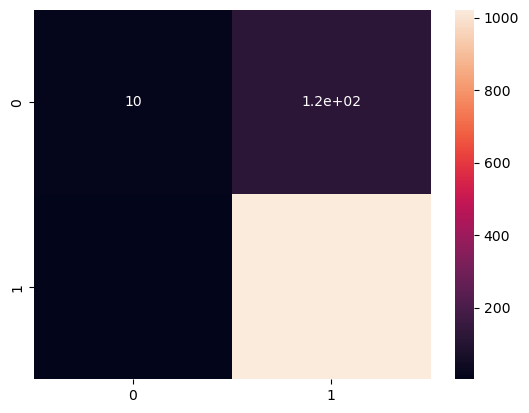

Accuracy: 0.8935064935064935
MCC: 0.943239501615136


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X = data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Confusion matrix
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

print(f'Accuracy: {rf.score(X_test, y_test)}')

# Calculate MCC
from sklearn.metrics import matthews_corrcoef, f1_score

mcc = f1_score(y_test, y_pred)
print(f'MCC: {mcc}')

In [18]:
X_train

,αα,αβασιμα,αβασιμες,αβασιμη,αβασιμης,αβασιμο,αβασιμοι,αβασιμος,αβασιμου,αβασιμων,...,ωρα,ωραριο,ωραριου,ωρας,ωρες,ωρομισθιο,ωρομισθιου,ωρων,ωφελεια,ωφελειας
8691.html,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1711.html,0.000000,0.000000,0.0,0.018405,0.000000,0.000000,0.0,0.010460,0.000000,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
7671.html,0.000000,0.010688,0.0,0.015340,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
7013.html,0.008698,0.000000,0.0,0.004102,0.000000,0.006967,0.0,0.013986,0.007622,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4553.html,0.067627,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6128.html,0.000000,0.000000,0.0,0.022056,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.138094,0.000000
6006.html,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.009037,0.000000,0.00000,...,0.046133,0.0,0.054692,0.000000,0.348373,0.095302,0.0,0.131794,0.000000,0.016474
889.html,0.062205,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.020261
8391.html,0.000000,0.011472,0.0,0.004117,0.000000,0.000000,0.0,0.000000,0.007649,0.00805,...,0.179143,0.0,0.018878,0.009736,0.298309,0.000000,0.0,0.059708,0.000000,0.000000


In [19]:
cm

array([[  10,  121],
       [   2, 1022]])

In [20]:
y

1004.html    1
1006.html    1
1008.html    1
1010.html    1
1012.html    0
            ..
9686.html    0
9688.html    1
969.html     1
9690.html    1
997.html     1
Name: target, Length: 3498, dtype: int64

In [21]:
decisions

,Label
Decision,
1004.html,1
1006.html,1
1008.html,1
1010.html,1
1012.html,0
...,...
9686.html,0
9688.html,1
969.html,1


## Creating a balanced dataset to work with ##

In [22]:
df['Label'] = decisions['Label'].values

df_0 = df[df['Label'] == 0]
df_1 = df[df['Label'] == 1]

df_0_sample = df_0.sample(380)
df_1_sample = df_1.sample(380)

df_resampled = pd.concat([df_0_sample, df_1_sample])
df_resampled['Label'].value_counts()

Label
0    380
1    380
Name: count, dtype: int64

In [23]:
df_resampled

,script,Label
1834.html,αριθμος αποφασης αριθμος αποφασης εφετει...,0
4134.html,αριθμος αποφασης αριθμος αποφασης μονομε...,0
1311.html,αριθμος αποφασης αριθμος αποφασης αριθμο...,0
9274.html,αριθμος αποφασης αριθμος αποφασης αριθ...,0
7898.html,αριθμος αποφασης αριθμος αποφασης μονομε...,0
...,...,...
4770.html,αριθμος αποφασης αριθμος αποφασης αριθμο...,1
3611.html,αριθμος αποφασης αριθμος αποφασης ελληνι...,1
8440.html,αριθμος αποφασης αριθμος αποφασης εφετει...,1
1559.html,αριθμος αποφασης αριθμος αποφασης τριμελ...,1


## TF-IDF VECTORIZER ##
TF-IDF Vectorization:

It uses TfidfVectorizer from scikit-learn to convert the text data (df_resampled['script']) into a matrix of TF-IDF features.
The parameters used in TfidfVectorizer are:

norm='l2': This normalizes the vectors to have an L2 norm (unit norm).

stop_words=stop_words: This removes common stop words (as defined by the stop_words variable) from the text before vectorizing.

max_features=5000: Limits the vocabulary to the 5000 most frequent terms.

Transformation:

The fit_transform method is applied to the text data (df_resampled['script']), which learns the vocabulary and IDF (Inverse Document Frequency) values from the data, and then transforms the text data into a TF-IDF weighted term-document matrix.
This matrix is then converted into a dense array using .toarray().

Creating a DataFrame:

The TF-IDF matrix is then converted into a Pandas DataFrame (data_resampled), with the same index as the original DataFrame (df_resampled.index) and with columns named after the terms in the vocabulary (tfidf.get_feature_names_out()).
Appending the Label:

The 'Label' column from the original df_resampled DataFrame is added to the data_resampled DataFrame, aligning by index.





In [24]:
tfidf = TfidfVectorizer(norm='l2', stop_words=stop_words, max_features=5000)
tfidf_matrix = tfidf.fit_transform(df_resampled['script']).toarray()

data_resampled = pd.DataFrame(tfidf_matrix, index=df_resampled.index, columns=tfidf.get_feature_names_out())
data_resampled['Label'] = df_resampled['Label'].values

## Classifiers ##

# 1. Random Forest Classifier #

Train shape: (509, 5000) | Test shape: (251, 5000)


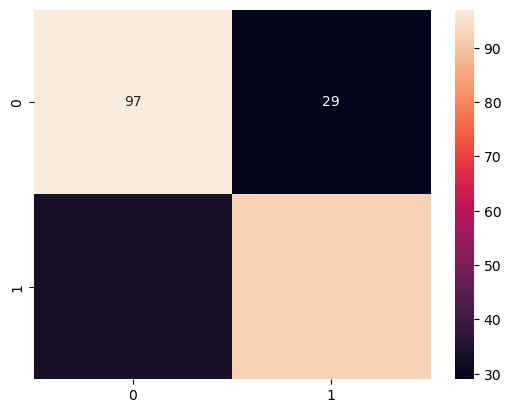

Accuracy: 0.7529880478087649
MCC: 0.7479674796747968


In [25]:
X = data_resampled.drop('Label', axis=1)
y = data_resampled['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Confusion matrix
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

print(f'Accuracy: {rf.score(X_test, y_test)}')

# Calculate MCC
from sklearn.metrics import matthews_corrcoef, f1_score

mcc = f1_score(y_test, y_pred)
print(f'MCC: {mcc}')

In [26]:
cm #confusion matrix : of prediction results on a classification problem. It shows the number of correct and incorrect predictions made by the model compared to the actual classifications in the test data

array([[97, 29],
       [33, 92]])

## 2. Support Vector Machines ##

Train shape: (509, 5000) | Test shape: (251, 5000)


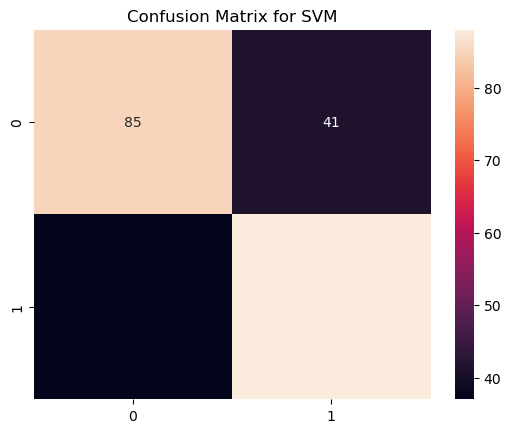

Accuracy: 0.6892430278884463
F1 Score: 0.6929133858267715


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # Import the SVM classifier
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split the data into features and labels
X = data_resampled.drop('Label', axis=1)
y = data_resampled['Label']

# Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

# Step 3: Initialize and train the SVM classifier
svm = SVC(random_state=42)
svm.fit(X_train, y_train)

# Step 4: Evaluate the SVM classifier
y_pred = svm.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for SVM')
plt.show()

# Print Accuracy
accuracy = svm.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score (which was previously misnamed as MCC)
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')


## 3. Linear Regression ## 

Train shape: (509, 5000) | Test shape: (251, 5000)


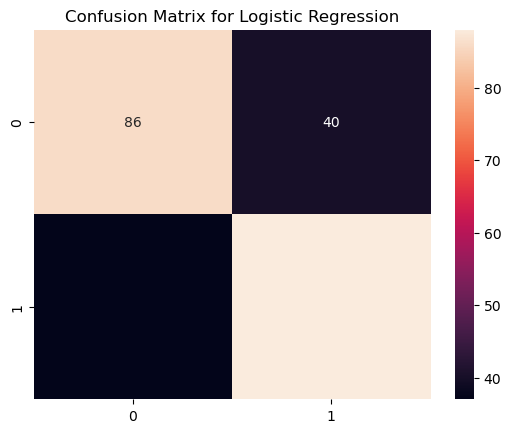

Accuracy: 0.6932270916334662
F1 Score: 0.6956521739130435


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # Import Logistic Regression
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split the data into features and labels
X = data_resampled.drop('Label', axis=1)
y = data_resampled['Label']

# Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

# Step 3: Initialize and train the Logistic Regression classifier
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train, y_train)

# Step 4: Evaluate the Logistic Regression classifier
y_pred = lr.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Print Accuracy
accuracy = lr.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')
